In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd

path = r"C:\Users\User\Downloads\Regional_Database_Food+Crime2.xlsx"

dfs = pd.read_excel(path, sheet_name=None)  # dict: {имя_листа: DataFrame}
# пример доступа к одному листу:


In [5]:
path = r"C:\Users\User\Downloads\Regional_Database_Food+Crime2.xlsx"

crime = pd.read_excel(path, sheet_name="Crime_Economics")
food  = pd.read_excel(path, sheet_name="FoodConsumption_TimeSeries")
expandatures = pd.read_excel(path, sheet_name="FoodExpenditure_Rubles").drop(columns=["Federal_District"])
nutrition = pd.read_excel(path, sheet_name="Nutrition_Analysis").drop(columns=["Federal_District"])
share = pd.read_excel(path, "FoodExpenditure_Share").drop(columns=["Federal_District"])


In [6]:
price_level = pd.read_excel(r"C:\Users\User\Downloads\Average_Cost_Rub_per_Unit.xlsx")
cols_to_exclude = ["region", "year", "Federal_District"]

num_cols = price_level.columns.difference(cols_to_exclude)

price_level[num_cols] = price_level[num_cols] * 12



In [7]:
import pandas as pd

m12 = crime.merge(food , on=["region", "year"], how="inner")
print(m12.shape)

m123 = m12.merge(expandatures , on=["region", "year"], how="inner")
print(m123.shape)

m1234 = m123.merge(nutrition , on=["region", "year"], how="inner")
print(m1234.shape)

m12345 = m1234.merge(share , on=["region", "year"], how="inner")
print(m12345.shape)

panel = m12345.merge(price_level , on=["region", "year"], how="inner")
print(panel.shape)



(492, 31)
(492, 41)
(492, 47)
(492, 57)
(492, 68)


In [8]:

panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [9]:
factor_vars = ['grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
       'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
       'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
       'Fruits_Cost_Rub_per_kg'
]

crime_vars = [
    "crime_rate", "crime_people", "crime_rate_severe",
    "crime_people_severe", "crime_rate_econ", "crime_people_econ",
    "crime_rate_corruption"
]


In [10]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

df = panel.sort_values(["region", "year"]).copy()

max_lag = 2
alpha = 0.05

rows_factor_to_crime = []

for factor in factor_vars:
    if factor not in df.columns:
        continue
    if not np.issubdtype(df[factor].dtype, np.number):
        continue

    for crime in crime_vars:
        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[factor].shift(lag)   # прошлый фактор [web:35][web:110]
            y = df[crime]                                 # текущая преступность

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])            # [web:109]
            rows_factor_to_crime.append({
                "source": factor,
                "target": crime,
                "direction": "factor→crime",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_factor_to_crime = pd.DataFrame(rows_factor_to_crime)


In [11]:
rows_crime_to_factor = []

for crime in crime_vars:
    for factor in factor_vars:
        if factor not in df.columns:
            continue
        if not np.issubdtype(df[factor].dtype, np.number):
            continue

        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[crime].shift(lag)    # прошлая преступность
            y = df[factor]                                # текущий фактор

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])
            rows_crime_to_factor.append({
                "source": crime,
                "target": factor,
                "direction": "crime→factor",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_crime_to_factor = pd.DataFrame(rows_crime_to_factor)


In [12]:
alpha = 0.05

sig1 = df_factor_to_crime[df_factor_to_crime["p_value"] < alpha].copy()
sig2 = df_crime_to_factor[df_crime_to_factor["p_value"] < alpha].copy()

for d in (sig1, sig2):
    d["abs_r"] = d["r"].abs()

sig1 = sig1.sort_values(["abs_r", "lag"], ascending=[False, True])
sig2 = sig2.sort_values(["abs_r", "lag"], ascending=[False, True])

# добавим столбец с направлением
sig1["direction"] = "factor→crime"
sig2["direction"] = "crime→factor"

# возьмём только нужные столбцы (подставь свои реальные имена переменных)
cols = ["direction", "source", "target", "lag", "r", "p_value", "abs_r"]

top1 = sig1.head(30)[cols]
top2 = sig2.head(30)[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl = top_all
df_correl


,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,2,0.544926,9.224743e-27,0.544926
1,factor→crime,Vegetables_Cost_Rub_per_kg,crime_people_severe,2,0.542258,1.813388e-26,0.542258
2,factor→crime,Vegetables_Cost_Rub_per_kg,crime_people_severe,1,0.516233,2.646825e-29,0.516233
3,factor→crime,Milk_kg,crime_people,2,-0.514025,1.622386e-23,0.514025
4,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,1,0.513779,5.364368e-29,0.513779
5,factor→crime,Milk_kg,crime_people,1,-0.508911,2.141726e-28,0.508911
6,factor→crime,general,crime_people,2,0.499300,4.402872e-22,0.499300
7,factor→crime,Vegetables_kg,crime_people,1,-0.497938,4.479494e-27,0.497938
8,factor→crime,general,crime_people,1,0.497122,5.591819e-27,0.497122
9,factor→crime,Vegetables_kg,crime_people,2,-0.490217,3.118716e-21,0.490217


In [13]:
df_correl.to_excel("correlation_food_crime.xlsx")

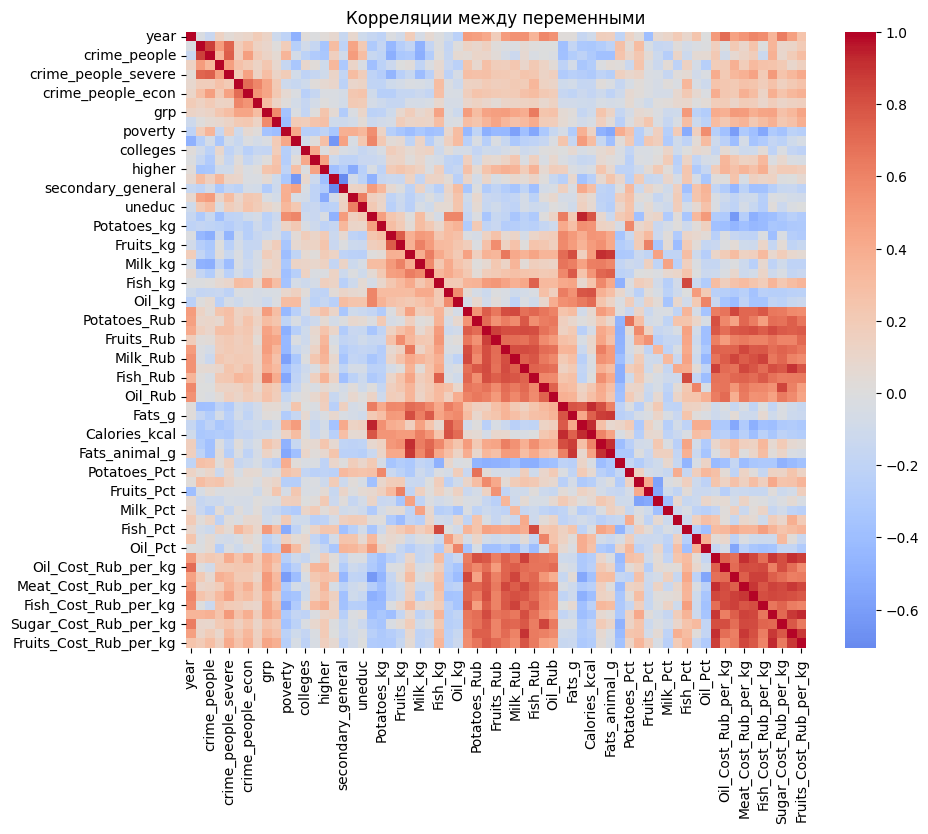

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = panel.select_dtypes(include=[np.number]).corr(method='pearson') 
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Корреляции между переменными')
plt.show()


In [15]:
panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [16]:
factor_vars = [
    'grp', 'gini', 'poverty', 'youth', 'colleges', 'uni', 'higher',
    'secondary_prof', 'secondary_general', 'general', 'uneduc',
    'Federal_District_x',
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg', 'Meat_kg',
    'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg',
    'Bread_Rub', 'Potatoes_Rub', 'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub',
    'Milk_Rub', 'Eggs_Rub', 'Fish_Rub', 'Sugar_Rub', 'Oil_Rub',
    'Proteins_g', 'Fats_g', 'Carbs_g', 'Calories_kcal',
    'Proteins_animal_g', 'Fats_animal_g',
    'Bread_Pct', 'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct',
    'Milk_Pct', 'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
    'Federal_District_y',
    'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
    'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
    'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
    'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
    'Fruits_Cost_Rub_per_kg'
]

crime_vars = [
    'crime_rate', 'crime_people', 'crime_rate_severe',
    'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
    'crime_rate_corruption'
]
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

df = panel.sort_values(["region", "year"]).copy()

max_lag = 5
alpha = 0.05

rows_f2c = []

for factor in factor_vars:
    if factor not in df.columns:
        continue
    if not np.issubdtype(df[factor].dtype, np.number):
        continue

    for crime in crime_vars:
        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[factor].shift(lag)   # прошлый фактор [web:35][web:110]
            y = df[crime]                                 # текущая преступность

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])            # [web:25][web:109]
            rows_f2c.append({
                "source": factor,
                "target": crime,
                "direction": "factor→crime",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_f2c = pd.DataFrame(rows_f2c)
rows_c2f = []

for crime in crime_vars:
    for factor in factor_vars:
        if factor not in df.columns:
            continue
        if not np.issubdtype(df[factor].dtype, np.number):
            continue

        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[crime].shift(lag)   # прошлая преступность
            y = df[factor]                               # текущий фактор

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])
            rows_c2f.append({
                "source": crime,
                "target": factor,
                "direction": "crime→factor",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_c2f = pd.DataFrame(rows_c2f)
alpha = 0.05

for d in (df_f2c, df_c2f):
    d["abs_r"] = d["r"].abs()

sig_f2c = df_f2c[df_f2c["p_value"] < alpha].sort_values(
    ["abs_r", "lag"], ascending=[False, True]
)
sig_c2f = df_c2f[df_c2f["p_value"] < alpha].sort_values(
    ["abs_r", "lag"], ascending=[False, True]
)
cols = ["direction", "source", "target", "lag", "r", "p_value", "abs_r"]
top1 = sig_f2c[cols]
top2 = sig_c2f[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl = top_all
df_correl





,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,general,crime_people,4,0.591051,7.974825e-17,0.591051
1,factor→crime,general,crime_people,5,0.586978,6.801939e-09,0.586978
2,factor→crime,general,crime_rate,4,0.554695,1.291887e-14,0.554695
3,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,3,0.552309,4.790370e-21,0.552309
4,factor→crime,general,crime_people,3,0.546593,1.450663e-20,0.546593
...,...,...,...,...,...,...,...
2137,crime→factor,crime_rate_severe,Sugar_Pct,1,-0.099197,4.470627e-02,0.099197
2138,crime→factor,crime_rate_econ,Proteins_g,1,-0.098914,4.532293e-02,0.098914
2139,crime→factor,crime_rate_corruption,Fats_g,1,-0.097588,4.830339e-02,0.097588
2140,crime→factor,crime_people_econ,Carbs_g,1,-0.097357,4.883826e-02,0.097357


In [17]:
# предполагаем, что sig_f2c и sig_c2f уже отфильтрованы по p_value < alpha
# и содержат колонки: source, target, direction, lag, r, p_value

# ключ для пары без направления
sig_f2c["pair"] = sig_f2c["source"] + "||" + sig_f2c["target"]
sig_c2f["pair"] = sig_c2f["target"] + "||" + sig_c2f["source"]
# во втором случае меняем местами, чтобы (factor, crime) совпадали по строке

# пары, где есть и factor→crime, и crime→factor
both_pairs = set(sig_f2c["pair"]) & set(sig_c2f["pair"])

# оставляем только «односторонние» связи
sig_f2c_clean = sig_f2c[~sig_f2c["pair"].isin(both_pairs)].drop(columns=["pair"])
sig_c2f_clean = sig_c2f[~sig_c2f["pair"].isin(both_pairs)].drop(columns=["pair"])

top1 = sig_f2c_clean[cols]
top2 = sig_c2f_clean[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl_clean = top_all
df_correl_clean


,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,uneduc,crime_rate_econ,4,0.365724,0.000001,0.365724
1,factor→crime,Sugar_Cost_Rub_per_kg,crime_people,4,0.326358,0.000020,0.326358
2,factor→crime,Sugar_Cost_Rub_per_kg,crime_people,5,0.317899,0.003610,0.317899
3,factor→crime,Sugar_Cost_Rub_per_kg,crime_rate,5,0.298236,0.006500,0.298236
4,factor→crime,Meat_Pct,crime_people,5,-0.295850,0.006963,0.295850
...,...,...,...,...,...,...,...
150,crime→factor,crime_people,Oil_Cost_Rub_per_kg,1,-0.100302,0.042368,0.100302
151,crime→factor,crime_rate_corruption,Carbs_g,1,-0.099711,0.043606,0.099711
152,crime→factor,crime_rate_corruption,Meat_Rub,1,0.099591,0.043861,0.099591
153,crime→factor,crime_rate_severe,Sugar_Pct,1,-0.099197,0.044706,0.099197


In [18]:
panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [19]:
arr = df_correl

In [20]:
arr.source


0                     general
1                     general
2                     general
3        Milk_Cost_Rub_per_kg
4                     general
                ...          
2137        crime_rate_severe
2138          crime_rate_econ
2139    crime_rate_corruption
2140        crime_people_econ
2141      crime_people_severe
Name: source, Length: 2142, dtype: object

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

food_cols = [
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg', 'Meat_kg',
    'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg',
    'Bread_Rub', 'Potatoes_Rub', 'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub',
    'Milk_Rub', 'Eggs_Rub', 'Fish_Rub', 'Sugar_Rub', 'Oil_Rub',
    'Proteins_g', 'Fats_g', 'Carbs_g', 'Calories_kcal',
    'Proteins_animal_g', 'Fats_animal_g',
    'Bread_Pct', 'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct',
    'Milk_Pct', 'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
    'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
    'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
    'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
    'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
    'Fruits_Cost_Rub_per_kg'
]

crime_cols = [
    'crime_rate', 'crime_people', 'crime_rate_severe',
    'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
    'crime_rate_corruption'
]

alpha = 0.05
rows = []

for f in food_cols:
    for c in crime_cols:
        x = panel[f]
        y = panel[c]
        mask = x.notna() & y.notna()
        if mask.sum() < 3:
            continue
        r, p = pearsonr(x[mask], y[mask])
        if p < alpha:          # оставить только значимые
            rows.append({"food_var": f, "crime_var": c, "r": r, "p_value": p})

res_sig = pd.DataFrame(rows)
res_sig["abs_r"] = res_sig["r"].abs()
res_sig = res_sig.sort_values("abs_r", ascending=False)
corr_pearson = pd.concat([res_sig])

In [22]:
corr_pearson

,food_var,crime_var,r,p_value,abs_r
14,Vegetables_kg,crime_people,-0.501829,9.621043e-33,0.501829
30,Milk_kg,crime_people,-0.500649,1.420329e-32,0.500649
201,Vegetables_Cost_Rub_per_kg,crime_people_severe,0.493681,1.372754e-31,0.493681
29,Milk_kg,crime_rate,-0.476929,2.604247e-29,0.476929
16,Vegetables_kg,crime_people_severe,-0.459538,4.480378e-27,0.459538
...,...,...,...,...,...
59,Vegetables_Rub,crime_people,0.094291,3.654530e-02,0.094291
138,Potatoes_Pct,crime_people_severe,0.093081,3.902973e-02,0.093081
108,Fats_g,crime_rate_corruption,-0.091158,4.327566e-02,0.091158
156,Fish_Pct,crime_rate_corruption,0.089793,4.651772e-02,0.089793


<Axes: xlabel='Milk_kg', ylabel='crime_rate'>

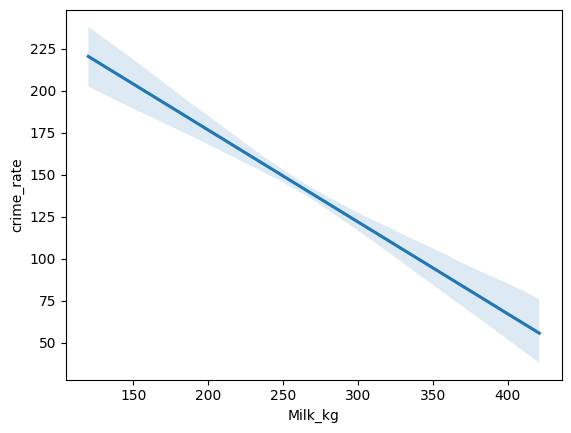

In [23]:
sns.regplot(data = panel, x = 'Milk_kg', y = 'crime_rate', scatter = False)


In [56]:
import statsmodels.formula.api as smf
import pandas as pd

food_vars = [
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg',
    'Meat_kg', 'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg'
]

price_vars = ['Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
       'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
       'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
       'Fruits_Cost_Rub_per_kg'
]
results = []

for v in food_vars:
    # 1. простая модель
    m1 = smf.ols(f"crime_rate ~ {v}", data=panel).fit()

    # 2. с контролем (доход, бедность, возраст, образование + цена/расходы на молоко как в примере)
    m2 = smf.ols(
        f"crime_rate ~ {v} + grp + poverty + youth + higher ",
        data=panel
    ).fit()

    results.append({
        "var": v,
        "beta_simple": m1.params[v],
        "p_simple": m1.pvalues[v],
        "beta_ctrl": m2.params[v],
        "p_ctrl": m2.pvalues[v]
    })

res_df = pd.DataFrame(results)
print(res_df)





             var  beta_simple      p_simple  beta_ctrl        p_ctrl
0       Bread_kg    -0.739585  5.484234e-12  -1.189479  4.760113e-22
1    Potatoes_kg    -0.613221  7.943274e-05  -0.587420  4.907769e-05
2  Vegetables_kg    -1.034140  2.679541e-25  -0.712562  7.131030e-14
3      Fruits_kg    -0.794564  3.768128e-09  -0.278766  3.134668e-02
4        Meat_kg    -0.625902  4.280937e-05  -0.419766  3.850580e-03
5        Milk_kg    -0.547089  2.604247e-29  -0.424855  4.956035e-19
6     Eggs_units    -0.286777  8.775339e-05  -0.304854  7.636620e-06
7        Fish_kg    -0.063000  8.568268e-01   0.182687  5.968781e-01
8       Sugar_kg    -1.459610  8.175790e-05  -1.778617  7.503432e-08
9         Oil_kg     0.035661  9.739718e-01  -0.361583  7.259592e-01


In [ ]:
panel.columns

Index(['region', 'year', 'crime_rate', 'crime_people', 'crime_rate_severe',
       'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
       'crime_rate_corruption', 'grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Federal_District_x', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct', 'Federal_District_y',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_

In [ ]:
from linearmodels.panel import PanelOLS
import pandas as pd

# пусть твой датафрейм называется panel
# region – идентификатор единицы, year – время
panel_fe = panel.set_index(["region", "year"]).sort_index()
exog_vars = ["Milk_kg"]
X = panel_fe[exog_vars]
y = panel_fe["crime_rate"]

mod = PanelOLS(
    y,
    X,
    entity_effects=True,   # фиксированные эффекты регионов
    time_effects=True      # фиксированные эффекты лет
)

res = mod.fit(cov_type="clustered", cluster_entity=True)  # кластер-robust по регионам
print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.0202
Estimator:                   PanelOLS   R-squared (Between):             -0.3539
No. Observations:                 492   R-squared (Within):               0.0088
Date:                 Вс, дек 14 2025   R-squared (Overall):             -0.3523
Time:                        10:06:20   Log-likelihood                   -1817.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.3459
Entities:                          82   P-value                           0.0041
Avg Obs:                       6.0000   Distribution:                   F(1,404)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.036
                            

In [ ]:
panel

In [54]:
import statsmodels.formula.api as smf

# 1. Простая модель
m1 = smf.ols("crime_rate ~ Milk_kg", data=panel).fit()

# 2. С контролем третьих факторов (пример: доход, бедность, возраст, образование)
m2 = smf.ols("crime_rate ~ Milk_kg + grp + poverty + youth + higher + gini + Milk_Cost_Rub_per_kg", data=panel).fit()

print(m1.params["Milk_kg"], m1.pvalues["Milk_kg"])
print(m2.params["Milk_kg"], m2.pvalues["Milk_kg"])



-0.5470887854414079 2.604246813401609e-29
-0.3054423845420479 3.076340954710778e-10


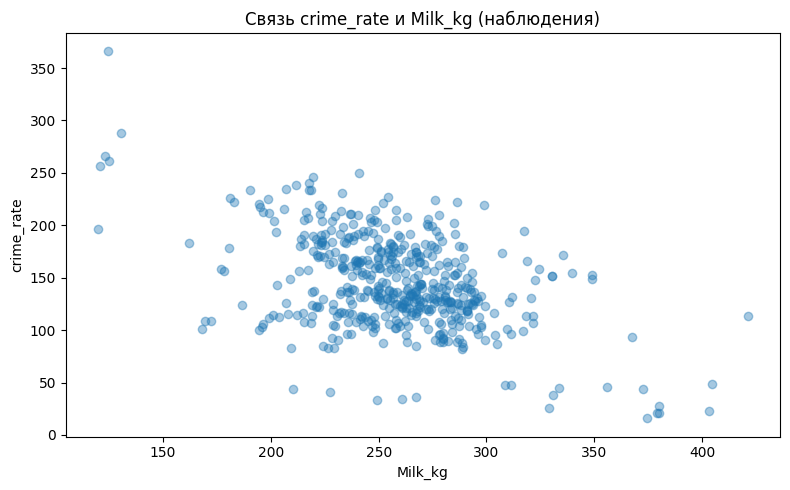

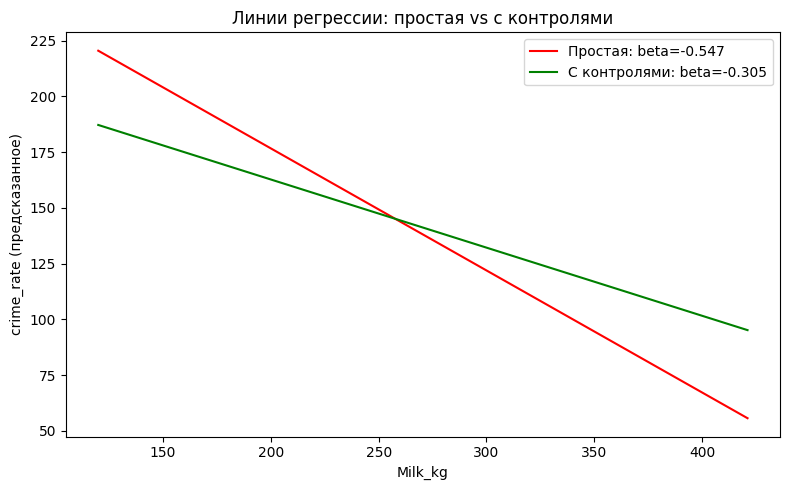

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Scatterplot отдельно
plt.figure(figsize=(8, 5))
plt.scatter(panel["Milk_kg"], panel["crime_rate"], alpha=0.4)
plt.xlabel("Milk_kg")
plt.ylabel("crime_rate")
plt.title("Связь crime_rate и Milk_kg (наблюдения)")
plt.tight_layout()
plt.show()

# 2. Линии двух регрессий на отдельном графике
x_min, x_max = panel["Milk_kg"].min(), panel["Milk_kg"].max()
x_grid = np.linspace(x_min, x_max, 100)

pred_m1 = m1.params["Intercept"] + m1.params["Milk_kg"] * x_grid  # [web:86]

ctrl_means = panel[["grp", "poverty", "youth", "higher", "gini", "Milk_Cost_Rub_per_kg"]].mean()
pred_m2 = (
    m2.params["Intercept"]
    + m2.params["Milk_kg"] * x_grid
    + m2.params["grp"] * ctrl_means["grp"]
    + m2.params["poverty"] * ctrl_means["poverty"]
    + m2.params["youth"] * ctrl_means["youth"]
    + m2.params["higher"] * ctrl_means["higher"]
    + m2.params["gini"] * ctrl_means["gini"]
    + m2.params["Milk_Cost_Rub_per_kg"] * ctrl_means["Milk_Cost_Rub_per_kg"]
)  # [web:86]

plt.figure(figsize=(8, 5))
plt.plot(x_grid, pred_m1, color="red", label=f"Простая: beta={m1.params['Milk_kg']:.3f}")
plt.plot(x_grid, pred_m2, color="green", label=f"С контролями: beta={m2.params['Milk_kg']:.3f}")
plt.xlabel("Milk_kg")
plt.ylabel("crime_rate (предсказанное)")
plt.title("Линии регрессии: простая vs с контролями")
plt.legend()
plt.tight_layout()
plt.show()


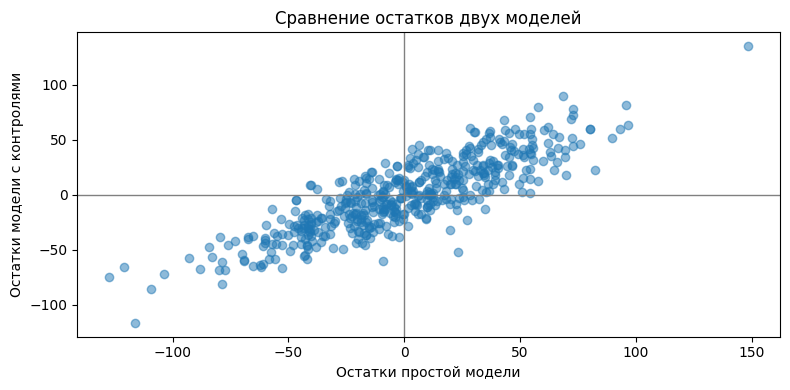

In [ ]:
# Остатки простой модели vs остатки с контролями
resid1 = m1.resid
resid2 = m2.resid

plt.figure(figsize=(8, 4))
plt.scatter(resid1, resid2, alpha=0.5)
plt.axhline(0, color="grey", linewidth=1)
plt.axvline(0, color="grey", linewidth=1)
plt.xlabel("Остатки простой модели")
plt.ylabel("Остатки модели с контролями")
plt.title("Сравнение остатков двух моделей")
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
from scipy.stats import pearsonr

results = []

for fd, df_fd in panel.groupby("Federal_District_x"):
    sub = df_fd[["Milk_kg", "crime_rate"]].dropna()
    # чтобы была осмысленная корреляция
    if len(sub) < 3 or sub["Milk_kg"].nunique() < 2 or sub["crime_rate"].nunique() < 2:
        continue
    
    r, p = pearsonr(sub["Milk_kg"], sub["crime_rate"])  # [web:1][web:3]
    results.append({
        "Federal_District": fd,
        "r_Milk_crime_rate": r,
        "p_value": p,
        "n": len(sub),
    })

corr_fd = pd.DataFrame(results)
print(corr_fd)


    Federal_District  r_Milk_crime_rate       p_value    n
0    Дальневосточный          -0.495220  5.753624e-05   60
1        Приволжский          -0.056655  6.087351e-01   84
2    Северо-Западный          -0.123443  3.234072e-01   66
3  Северо-Кавказский          -0.720958  7.051396e-05   24
4          Сибирский          -0.681703  2.957241e-10   66
5          Уральский          -0.353004  3.470430e-02   36
6        Центральный           0.056429  5.618683e-01  108
7              Южный          -0.004575  9.753808e-01   48


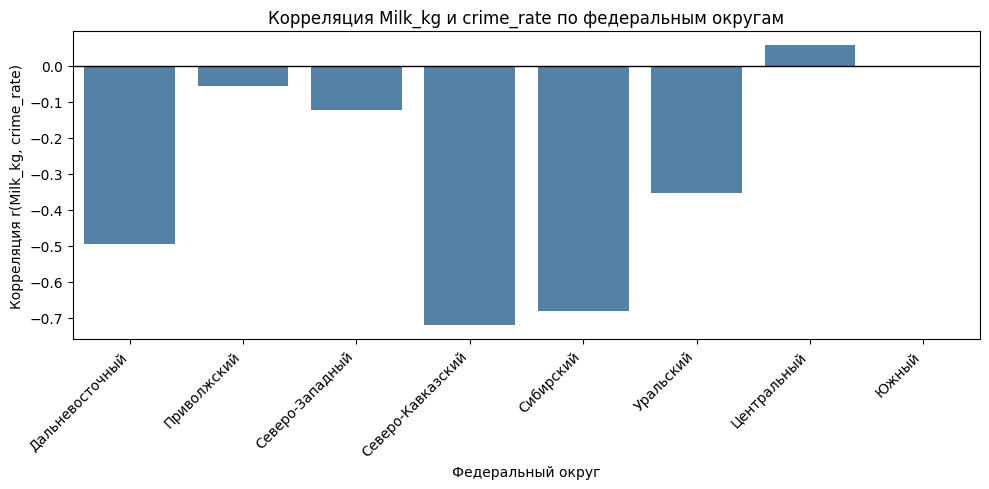

In [ ]:
import seaborn as sns3.470430e-02
import matplotlib.pyplot as plt

# corr_fd уже посчитан как:
# columns: Federal_District, r_Milk_crime_rate, p_value, n

plt.figure(figsize=(10, 5))
sns.barplot(
    data=corr_fd,
    x="Federal_District",
    y="r_Milk_crime_rate",
    color="steelblue"
)  # [web:93][web:100]

plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Корреляция r(Milk_kg, crime_rate)")
plt.xlabel("Федеральный округ")
plt.title("Корреляция Milk_kg и crime_rate по федеральным округам")
plt.tight_layout()
plt.show()


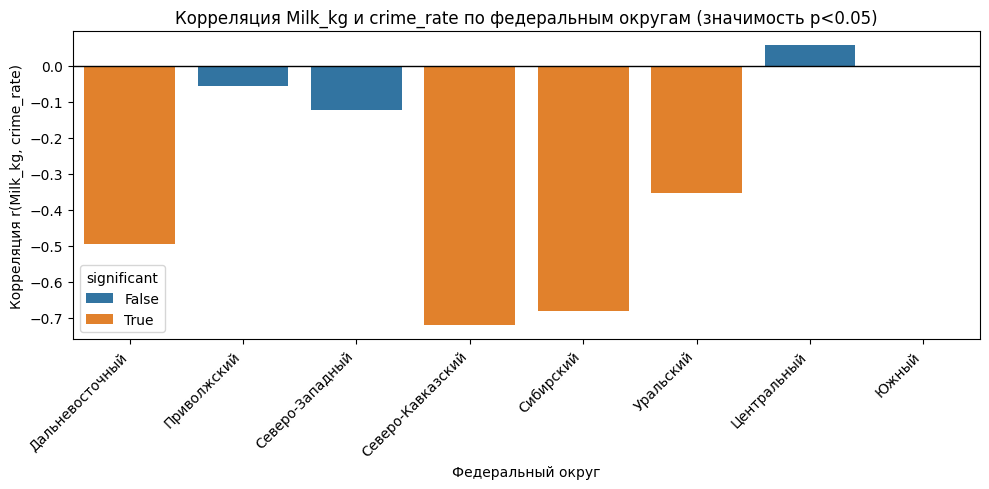

In [ ]:
corr_fd["significant"] = corr_fd["p_value"] < 0.05

plt.figure(figsize=(10, 5))
sns.barplot(
    data=corr_fd,
    x="Federal_District",
    y="r_Milk_crime_rate",
    hue="significant",
    dodge=False
)  # [web:93][web:95]

plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Корреляция r(Milk_kg, crime_rate)")
plt.xlabel("Федеральный округ")
plt.title("Корреляция Milk_kg и crime_rate по федеральным округам (значимость p<0.05)")
plt.tight_layout()
plt.show()


In [30]:
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT  # [web:123][web:128]

# те же регрессоры, что в m2
exog_vars = ["Milk_kg", "grp", "poverty", "youth", "higher", "gini", "Milk_Cost_Rub_per_kg"]

X = sm.add_constant(panel[exog_vars])
y = panel["crime_rate"]

# OLS для сравнения
ols = sm.OLS(y, X).fit()
print("OLS:\n", ols.params["Milk_kg"], ols.pvalues["Milk_kg"])

# Robust Linear Model (Huber)
rlm_mod = sm.RLM(y, X, M=HuberT())  # Huber M‑оценка [web:123][web:125]
rlm_res = rlm_mod.fit()             # по умолчанию scale_est='mad' [web:127]
print("RLM (Huber):\n", rlm_res.params["Milk_kg"])


OLS:
 -0.3054423845420479 3.076340954710778e-10
RLM (Huber):
 -0.2956810614168159


In [31]:
year_median = panel["year"].median()
panel_early = panel[panel["year"] <= year_median]
panel_late  = panel[panel["year"] >  year_median]

m_early = smf.ols(
    "crime_rate ~ Milk_kg + grp + poverty + youth + higher + gini + Milk_Cost_Rub_per_kg",
    data=panel_early
).fit()
m_late = smf.ols(
    "crime_rate ~ Milk_kg + grp + poverty + youth + higher + gini + Milk_Cost_Rub_per_kg",
    data=panel_late
).fit()

print("EARLY:", m_early.params["Milk_kg"], m_early.pvalues["Milk_kg"])
print("LATE :", m_late.params["Milk_kg"], m_late.pvalues["Milk_kg"])


EARLY: -0.264585055195941 0.0001401458475724041
LATE : -0.22167229397841004 0.0006564446212259147


In [33]:
# квантиль 5% и 95% по crime_rate и Milk_kg
import statsmodels.formula.api as smf

m2 = smf.ols(
    "crime_rate ~ Milk_kg + grp + poverty + youth + higher + gini + Milk_Cost_Rub_per_kg",
    data=panel
).fit()


q_low_crime, q_high_crime = panel["crime_rate"].quantile([0.05, 0.95])
q_low_milk,  q_high_milk  = panel["Milk_kg"].quantile([0.05, 0.95])

panel_trim = panel[
    (panel["crime_rate"].between(q_low_crime, q_high_crime)) &
    (panel["Milk_kg"].between(q_low_milk, q_high_milk))
]

m_full = m2  # твоя исходная модель
m_trim = smf.ols(
    "crime_rate ~ Milk_kg + grp + poverty + youth + higher + gini + Milk_Cost_Rub_per_kg",
    data=panel_trim
).fit()

print("FULL :", m_full.params["Milk_kg"], m_full.pvalues["Milk_kg"])
print("TRIM :", m_trim.params["Milk_kg"], m_trim.pvalues["Milk_kg"])


FULL : -0.3054423845420479 3.076340954710778e-10
TRIM : -0.1318050372668159 0.025428031514409966


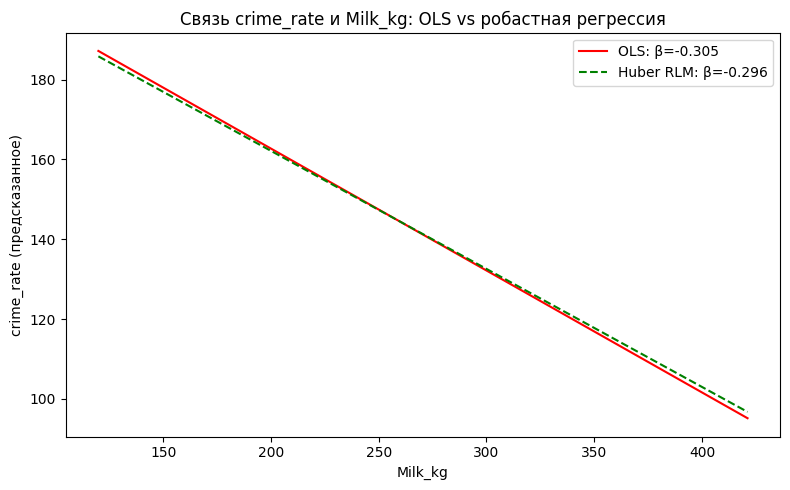

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Диапазон по Milk_kg
x_min, x_max = panel["Milk_kg"].min(), panel["Milk_kg"].max()
x_grid = np.linspace(x_min, x_max, 100)

# Прогнозы из OLS и RLM (по тем же регрессорам, держим контролы на средних)
ctrl_means = panel[["grp", "poverty", "youth", "higher", "gini", "Milk_Cost_Rub_per_kg"]].mean()

def predict_line(params):
    return (
        params["const"]
        + params["Milk_kg"] * x_grid
        + params["grp"] * ctrl_means["grp"]
        + params["poverty"] * ctrl_means["poverty"]
        + params["youth"] * ctrl_means["youth"]
        + params["higher"] * ctrl_means["higher"]
        + params["gini"] * ctrl_means["gini"]
        + params["Milk_Cost_Rub_per_kg"] * ctrl_means["Milk_Cost_Rub_per_kg"]
    )

y_ols  = predict_line(ols.params)
y_rlm  = predict_line(rlm_res.params)

plt.figure(figsize=(8, 5))

# линии
plt.plot(x_grid, y_ols, color="red",  label=f"OLS: β={ols.params['Milk_kg']:.3f}")
plt.plot(x_grid, y_rlm, color="green", linestyle="--", label=f"Huber RLM: β={rlm_res.params['Milk_kg']:.3f}")

plt.xlabel("Milk_kg")
plt.ylabel("crime_rate (предсказанное)")
plt.title("Связь crime_rate и Milk_kg: OLS vs робастная регрессия")
plt.legend()
plt.tight_layout()
plt.show()


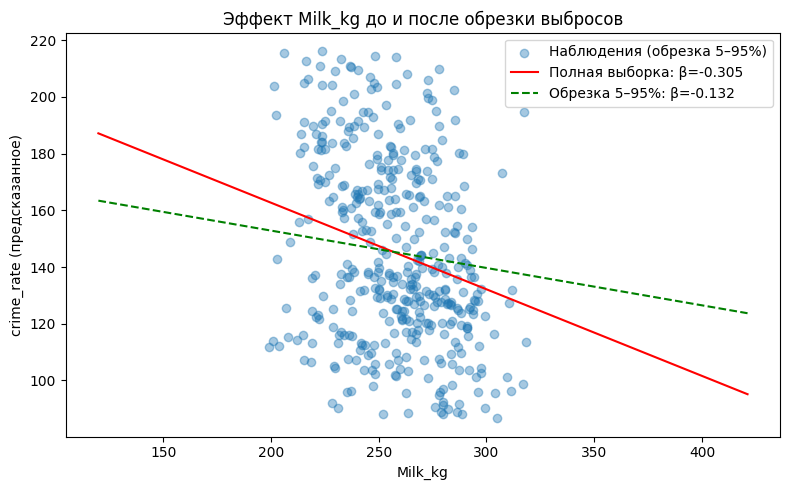

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# диапазон по Milk_kg для построения линий
x_min, x_max = panel["Milk_kg"].min(), panel["Milk_kg"].max()
x_grid = np.linspace(x_min, x_max, 100)

# прогнозы из полной и обрезанной моделей (контроли на средних)
ctrl_means_full = panel[["grp", "poverty", "youth", "higher", "gini", "Milk_Cost_Rub_per_kg"]].mean()
ctrl_means_trim = panel_trim[["grp", "poverty", "youth", "higher", "gini", "Milk_Cost_Rub_per_kg"]].mean()

def predict_line(params, means):
    return (
        params["Intercept"]
        + params["Milk_kg"] * x_grid
        + params["grp"] * means["grp"]
        + params["poverty"] * means["poverty"]
        + params["youth"] * means["youth"]
        + params["higher"] * means["higher"]
        + params["gini"] * means["gini"]
        + params["Milk_Cost_Rub_per_kg"] * means["Milk_Cost_Rub_per_kg"]
    )

y_full = predict_line(m_full.params, ctrl_means_full)
y_trim = predict_line(m_trim.params, ctrl_means_trim)

plt.figure(figsize=(8, 5))
# точечки только из «чистой» выборки, чтобы не захламлять
plt.scatter(panel_trim["Milk_kg"], panel_trim["crime_rate"], alpha=0.4, label="Наблюдения (обрезка 5–95%)")

plt.plot(x_grid, y_full, color="red",  label=f"Полная выборка: β={m_full.params['Milk_kg']:.3f}")
plt.plot(x_grid, y_trim, color="green", linestyle="--", label=f"Обрезка 5–95%: β={m_trim.params['Milk_kg']:.3f}")

plt.xlabel("Milk_kg")
plt.ylabel("crime_rate (предсказанное)")
plt.title("Эффект Milk_kg до и после обрезки выбросов")
plt.legend()
plt.tight_layout()
plt.show()



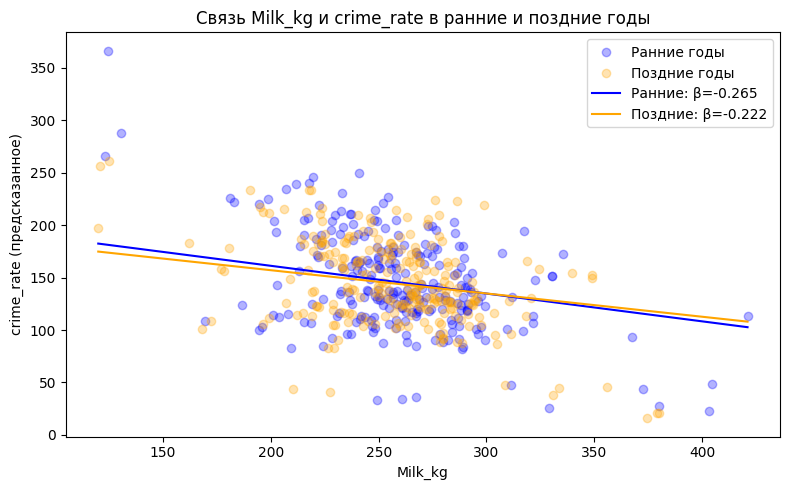

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Диапазон по Milk_kg
x_min, x_max = panel["Milk_kg"].min(), panel["Milk_kg"].max()
x_grid = np.linspace(x_min, x_max, 100)

# Средние контролей по подвыборкам
ctrl_early = panel_early[["grp", "poverty", "youth", "higher", "gini", "Milk_Cost_Rub_per_kg"]].mean()
ctrl_late  = panel_late[["grp", "poverty", "youth", "higher", "gini", "Milk_Cost_Rub_per_kg"]].mean()

def predict_line(params, means):
    return (
        params["Intercept"]
        + params["Milk_kg"] * x_grid
        + params["grp"] * means["grp"]
        + params["poverty"] * means["poverty"]
        + params["youth"] * means["youth"]
        + params["higher"] * means["higher"]
        + params["gini"] * means["gini"]
        + params["Milk_Cost_Rub_per_kg"] * means["Milk_Cost_Rub_per_kg"]
    )

y_early = predict_line(m_early.params, ctrl_early)
y_late  = predict_line(m_late.params,  ctrl_late)

plt.figure(figsize=(8, 5))

# Точки (можно слегка подсэмплировать, если их много)
plt.scatter(panel_early["Milk_kg"], panel_early["crime_rate"],
            alpha=0.3, color="blue", label="Ранние годы")
plt.scatter(panel_late["Milk_kg"], panel_late["crime_rate"],
            alpha=0.3, color="orange", label="Поздние годы")

# Линии
plt.plot(x_grid, y_early, color="blue",
         label=f"Ранние: β={m_early.params['Milk_kg']:.3f}")
plt.plot(
    x_grid,
    y_late,
    color="orange",
    label=f"Поздние: β={m_late.params['Milk_kg']:.3f}"
)


plt.xlabel("Milk_kg")
plt.ylabel("crime_rate (предсказанное)")
plt.title("Связь Milk_kg и crime_rate в ранние и поздние годы")
plt.legend()
plt.tight_layout()
plt.show()


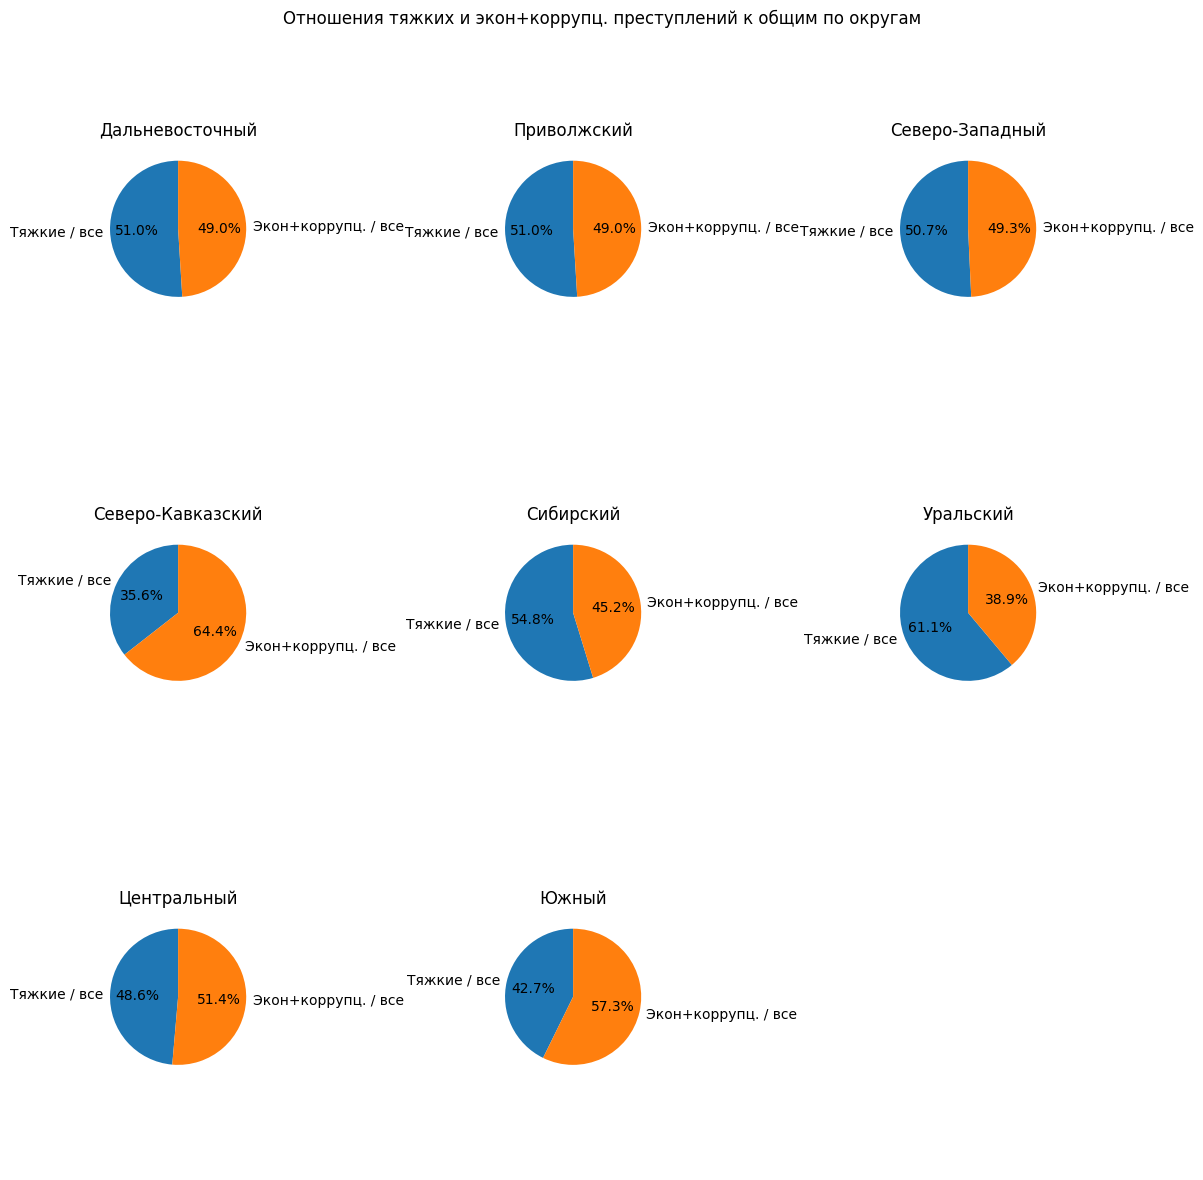

In [48]:
import pandas as pd

agg = panel.groupby("Federal_District_x", as_index=False)[
    ["crime_rate", "crime_rate_severe", "crime_rate_econ", "crime_rate_corruption"]
].mean()  # или sum [web:149]

agg["share_severe"] = agg["crime_rate_severe"] / agg["crime_rate"]
agg["share_econ_corr"] = (agg["crime_rate_econ"] + agg["crime_rate_corruption"]) / agg["crime_rate"]
import matplotlib.pyplot as plt
import numpy as np

labels = ["Тяжкие / все", "Экон+коррупц. / все"]

n_fd = len(agg)
n_cols = 3
n_rows = int(np.ceil(n_fd / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, (_, row) in enumerate(agg.iterrows()):
    sizes = [row["share_severe"], row["share_econ_corr"]]
    
    ax = axes[i]
    ax.pie(
        sizes,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
    )  # [web:145]
    ax.set_title(row["Federal_District_x"])

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Отношения тяжких и экон+коррупц. преступлений к общим по округам")
plt.tight_layout()
plt.show()


In [49]:
import pandas as pd

# агрегирование по округам
agg = panel.groupby("Federal_District_x", as_index=False)[
    ["crime_rate", "crime_rate_severe", "crime_rate_econ", "crime_rate_corruption"]
].mean()  # или sum, если хочешь объёмы [web:151][web:152]

# доли
agg["share_econ_corr"] = (agg["crime_rate_econ"] + agg["crime_rate_corruption"]) / agg["crime_rate"]
agg["share_severe"] = agg["crime_rate_severe"] / agg["crime_rate"]
table_econ_corr = agg[["Federal_District_x", "share_econ_corr"]].copy()
table_econ_corr.rename(columns={
    "Federal_District_x": "Federal_District",
    "share_econ_corr": "econ+corruption_share"
}, inplace=True)

table_severe = agg[["Federal_District_x", "share_severe"]].copy()
table_severe.rename(columns={
    "Federal_District_x": "Federal_District",
    "share_severe": "severe_share"
}, inplace=True)

table_all = agg[["Federal_District_x", "share_econ_corr", "share_severe"]].copy()
table_all.rename(columns={
    "Federal_District_x": "Federal_District",
    "share_econ_corr": "econ+corruption_share",
    "share_severe": "severe_share"
}, inplace=True)

print(table_all)


    Federal_District  econ+corruption_share  severe_share
0    Дальневосточный               0.040720      0.042340
1        Приволжский               0.057315      0.059558
2    Северо-Западный               0.051888      0.053429
3  Северо-Кавказский               0.111158      0.061326
4          Сибирский               0.035098      0.042477
5          Уральский               0.046283      0.072737
6        Центральный               0.054183      0.051294
7              Южный               0.059056      0.044060


In [50]:
import pandas as pd

agg = panel.groupby("Federal_District_x", as_index=False)[
    ["crime_rate", "crime_rate_severe", "crime_rate_econ", "crime_rate_corruption"]
].mean()  # средние уровни по округу [web:151][web:153]

agg["share_econ_corr"] = (agg["crime_rate_econ"] + agg["crime_rate_corruption"]) / agg["crime_rate"]
agg["share_severe"] = agg["crime_rate_severe"] / agg["crime_rate"]

table_all = agg.rename(columns={
    "Federal_District_x": "Federal_District",
    "crime_rate": "crime_total_level",
    "crime_rate_econ": "crime_econ_level",
    "crime_rate_corruption": "crime_corruption_level",
    "crime_rate_severe": "crime_severe_level",
    "share_econ_corr": "econ+corruption_share",
    "share_severe": "severe_share",
})

print(table_all)


    Federal_District  crime_total_level  crime_severe_level  crime_econ_level  \
0    Дальневосточный         188.415047            7.977561          7.386803   
1        Приволжский         128.217001            7.636362          7.175049   
2    Северо-Западный         160.927757            8.598258          8.028062   
3  Северо-Кавказский          56.451621            3.461975          6.040602   
4          Сибирский         189.498523            8.049247          6.374919   
5          Уральский         157.098097           11.426786          7.044190   
6        Центральный         123.106118            6.314545          6.477617   
7              Южный         122.313660            5.389110          6.988707   

   crime_corruption_level  econ+corruption_share  severe_share  
0                0.285392               0.040720      0.042340  
1                0.173712               0.057315      0.059558  
2                0.322162               0.051888      0.053429  
3         